In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = torchvision.transforms.functional.to_pil_image(inp)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
vid_file = 'videos/IMG_2139.MOV'

In [4]:

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


frames = torchvision.io.read_video(vid_file, 0, 3, pts_unit='sec')[0]
# change to [T,C,H,W] and normalize
frames = frames.transpose(2,3).transpose(1,2) / 255
frames.to('cuda')
frames.shape

torch.Size([90, 3, 1280, 720])

In [15]:
det = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [13]:
if 'pred' in globals():
    del pred
det.eval()
inputframes = frames[0:3]
pred = det(inputframes)
#pred

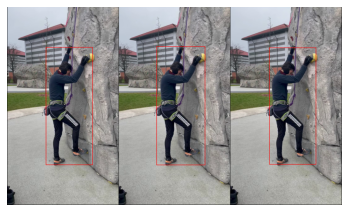

In [14]:
def draw_best_box(frames, preds):
    imgs = []
    for f, p in zip(frames, preds): 
        uint_inputframe = torchvision.transforms.functional.convert_image_dtype(f, torch.uint8)
        wboxes = torchvision.utils.draw_bounding_boxes(uint_inputframe, p['boxes'][0:1], colors=['red'], width=3)
        imgs.append(wboxes)
    return torchvision.utils.make_grid(imgs)

imshow(draw_best_box(inputframes, pred))